## Homework 4


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
df = pd.read_csv('bank-full.csv', sep=';')

In [27]:
features = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

df = df[features].copy()


In [28]:
df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [29]:
from sklearn.model_selection import train_test_split

In [32]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.y == 'yes').values
y_val = (df_val.y == 'yes').values
y_test = (df_test.y == 'yes').values

del df_train['y']
del df_val['y']
del df_test['y']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

In [34]:
df.dtypes[df.dtypes != 'object'].index

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [35]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%16s, %.3f' % (c, auc))

             age, 0.512
         balance, 0.589
             day, 0.526
        duration, 0.815
        campaign, 0.571
           pdays, 0.590
        previous, 0.599


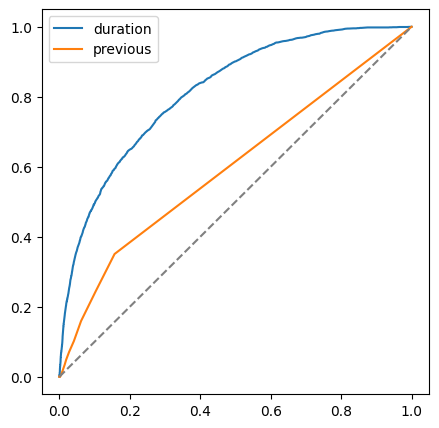

In [36]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.duration)
plt.plot(fpr, tpr, label='duration')

fpr, tpr, _ = roc_curve(y_train, df_train.previous)
plt.plot(fpr, tpr, label='previous')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

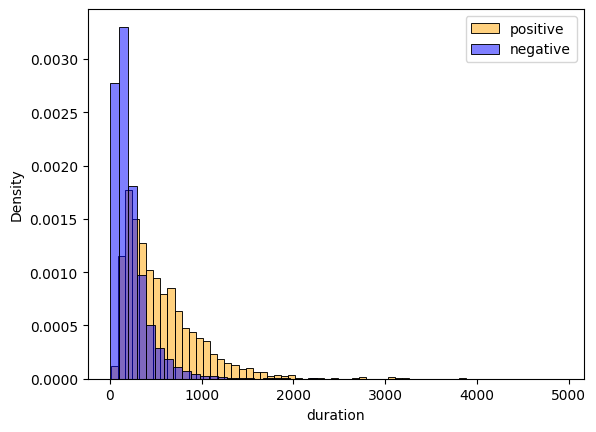

In [37]:
sns.histplot(df_train.duration[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.duration[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

## Question 2: Training the model


Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [38]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [39]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [40]:
roc_auc_score(y_val, y_pred)

0.899959438290254

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [41]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [42]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [43]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1098,7944,0,0
10,0.1,928,1502,170,6442
20,0.2,710,702,388,7242
30,0.3,569,425,529,7519
40,0.4,467,278,631,7666
50,0.5,368,193,730,7751
60,0.6,292,134,806,7810
70,0.7,226,106,872,7838
80,0.8,146,69,952,7875
90,0.9,74,30,1024,7914


In [44]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

0.265

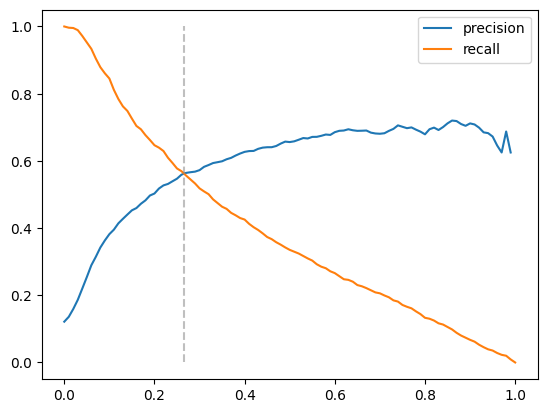

In [48]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.265, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [49]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [50]:
df_scores.loc[df_scores.f1.argmax()]

threshold       0.220000
tp            691.000000
fp            620.000000
fn            407.000000
tn           7324.000000
p               0.527079
r               0.629326
f1              0.573682
Name: 22, dtype: float64

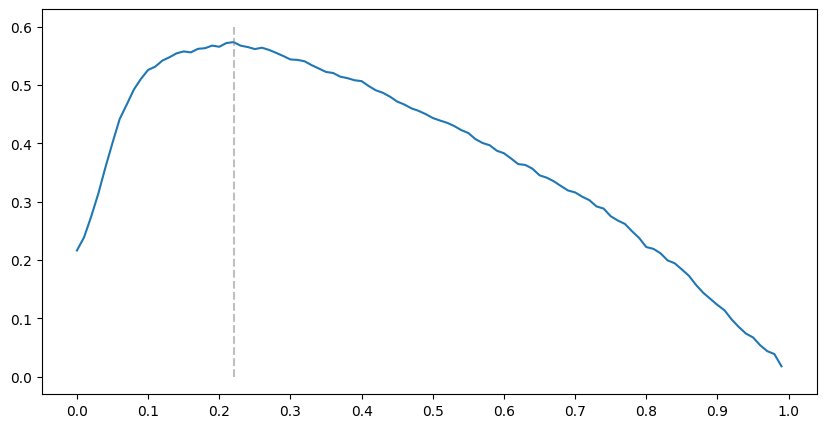

In [54]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.22, 0.0, 0.6, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

0.22

## Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [55]:
from sklearn.model_selection import KFold

In [56]:
columns = list(df.columns)
columns.remove('y')
columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [57]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [59]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


## Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [65]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=   1, 0.906 +- 0.006
